### Use Monte Carlo to Price American Options

In this homework you will implement your own option pricer using American Monte Carlo (Monte Carlo + Regression) Based on the method prescribed by Longstaff and Schwartz.


Basic Procedures:
    
* Step 1: Simulate asset price paths for $S(t_i), i=1,2,..N$
* Step 2: Option value can be calculated explicitly for $t_N$: $p_k(t_N) = \max(K - S_k(t_N), 0) $ for path k;
* Step 3: Set $i=N$;
* Step 4: Perform linear regression of $e^{-r\Delta t}p_k(t_i)$ against basis function $f_j(S(t_{i-1}))$
* Step 5: Use the regression coefficients to estimate the continuation value at $t_{i-1}$: $C(t_{i-1})=\sum^{J}_{j=0} \beta^{i}_{j} f_j(S(t_{i-1}))$
* Step 6: Set option value $p_k(t_{i-1}) = \max(\max(K - S_k(t_{i-1}),0), C_k(t_{i-1}))$
* Step 7: If $i>1$, Set $i=i-1$, go back to step 3. Otherwise terminate.

Return option price as the mean of $e^{-r\Delta t}p_k(t_{1})$

Some code has been provided to you.  Your task is to:

1. (Mandatory) Fill in the blanks where the code is missing (whereever there is an indication "YOUR CODE HERE") <br>
2. (Optional) Implement the following extension:<br>
  * Try with different number of basis functions (default is 6): 2,3,4,5,6,9,10,20. Plot the option prices against these different orders and write down the observations in your report. 
  * Try to extend the stock simulation model with stochastic volatility (Heston Model), i.e., replace $\sigma$ in the equation with a stochastic one:
$d S_t = r S_t dt + \sqrt{V_t} S_t dW_t $,  where $ d V_t = (\kappa - \theta V_t) dt + \eta \sqrt{V_t} d B_t$, $d[W_t, B_t] = \rho dt$.  Modify the pricer accordingly and compare the option price with the constant volatility case. 
3. (Mandatory) Prepare and submit a report in the form of powerpoint.  You will be asked to present it during the last lecture. 

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
%matplotlib inline

In [2]:
def sim_stock_price_GBM(S0, r, sigma, N_sim, N_T, dt):
        
    # Generate paths for underlying asset prices
    innovation = np.random.randn(N_sim, N_T)
    BM = np.zeros([N_sim, N_T+1])
    BM[:,0] = 0
    BM[:,1:] = innovation
    BM = np.cumsum(BM,axis=1)
    BM *= np.sqrt(dt)

    S = np.ones([N_sim, N_T+1])
    S[:,0] = 0
    S = S.cumsum(axis=1)
    S *= (r - 0.5*(sigma)**2)*dt
    S += sigma * BM
    S = S0*np.exp(S)
    
    return S

In [3]:
def AMC(S0,K,r,sigma, N_sim, T, dt, N_basis=6):
    N_T = int(T/dt)
    t = np.linspace(0,T,N_T+1)

    # Simulate stock prices
    S= sim_stock_price_GBM(S0, r, sigma, N_sim, N_T,dt)
    
    # Now backward induction & regression
    i = N_T
    
    Cont = np.zeros(N_sim)  # This stores the continuation value.

    while i > 1:
        # First calculate option price
        p = np.maximum(K - S[:, i], Cont) # YOUR CODE HERE
        x = S[:,i-1]  # This is your predictive variable (x). In your prediction you need to use x, x^2, x^3,...x^N, where N = # of basis
        # discounted option price
        p_disc = np.exp(-r*dt)*p   # This is your target variable (x)
        reg =  np.poly1d(np.polyfit(x, p_disc, N_basis)) # YOUR CODE HERE
        
        Cont = np.maximum(reg(x), 0)
        i = i - 1
    p = np.maximum(K - S[:, i], Cont) # YOUR CODE HERE
    return np.exp(-r*dt)*np.mean(p)
S0=100
K=95
r=0.1
sigma=0.23
N_sim=10000
T=2
dt=0.5
AMC(S0,K,r,sigma, N_sim, T, dt)

4.778251865208179

## European Put price for comparison

In [4]:
from scipy.stats import norm
def European_Put(S0,K,r,sigma,T):
    d1 = (np.log(S0/K) + (r + 0.5*(sigma)**2))*T/(sigma*np.sqrt(T)) 
    d2 = d1 - sigma*np.sqrt(T)
    return np.exp(-r*T)*K*norm.cdf(-d2) - S0*norm.cdf(-d1)

In [5]:
European_Put(S0,K,r,sigma,T)

3.494842856345061

In [6]:
S0=100
K=95
r=0.1
sigma=0.23
N_sim=10000
T=2
dt=0.5
AMC(S0,K,r,sigma, N_sim, T, dt)

4.804046664988097

In [7]:
def AMC_S(S):
    return AMC(S,K,r,sigma,N_sim,T,dt)

Text(0, 0.5, 'Put Price')

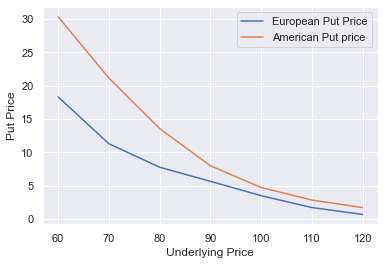

In [8]:
S= [60,70,80,90,100,110,120]
option_Eur = [European_Put(ss,K,r,sigma,T) for ss in S ]
option_Am = [AMC_S(ss) for ss in S]
plt.plot(S, option_Eur, label='European Put Price')
plt.plot(S, option_Am, label='American Put price')
plt.legend()
plt.xlabel('Underlying Price')
plt.ylabel('Put Price')

In [9]:
from ipywidgets import interact
import ipywidgets as widgets
interact(AMC_S, S=widgets.FloatSlider(min=50, max=120, step=5))

interactive(children=(FloatSlider(value=50.0, description='S', max=120.0, min=50.0, step=5.0), Output()), _dom…

<function __main__.AMC_S(S)>

C:\Users\95846\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: RankWarning: Polyfit may be poorly conditioned
  """
C:\Users\95846\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: RankWarning: Polyfit may be poorly conditioned
  """
C:\Users\95846\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: RankWarning: Polyfit may be poorly conditioned
  """
C:\Users\95846\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: RankWarning: Polyfit may be poorly conditioned
  """
C:\Users\95846\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: RankWarning: Polyfit may be poorly conditioned
  """
C:\Users\95846\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: RankWarning: Polyfit may be poorly conditioned
  """
C:\Users\95846\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: RankWarning: Polyfit may be poorly conditioned
  """
C:\Users\95846\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: RankWarning: Polyfit may be poorly conditioned
  """
C:\Users\95846\Anaconda3\lib\sit

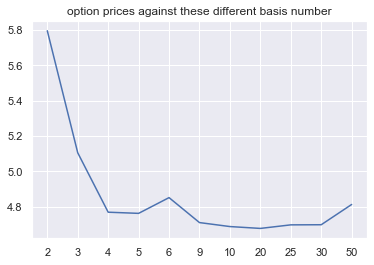

In [10]:
N_basis_list = [2,3,4,5,6,9,10,20, 25, 30,50]
option_price = []

for basis in N_basis_list:
    cur_price = AMC(S0,K,r,sigma, N_sim, T, dt, N_basis=basis)
    option_price.append(cur_price)
plt.plot(option_price)
plt.title("option prices against these different basis number")
plt.xticks([i for i in range(len(N_basis_list))], N_basis_list)
plt.show()

In [11]:
def sim_stock_hest(t0,T,S0,V0,N_t,r,kappa,theta, eta, rho, N_sim):
   
    dt = T/N_t
    t = np.linspace(t0,T,N_t+1)
    sdt = np.sqrt(dt)
    
    Z1 = np.random.randn(N_sim, N_t)
    Z2 = np.random.randn(N_sim, N_t)
    Z3 = rho*Z1 + np.sqrt(1-rho**2)*Z2
    
    S = np.zeros((N_sim, N_t+1))
    S[:,0] = S0
    
    V = np.zeros((N_sim, N_t+1))
    V[:,0] = V0

    for i in range(N_t):
        vol = np.sqrt(np.maximum(V[:,i],0))
        S[:,i+1] = S[:,i] + r*S[:,i]*dt + vol*S[:,i]*sdt*Z1[:,i] + 0.5*V[:,i]*S[:,i]*(Z1[:,i]**2 - 1)*dt
        V[:,i+1] = V[:,i] + kappa*(theta - V[:,i])*dt + eta*vol*sdt*Z3[:,i] + 0.25*(eta**2)*(Z3[:,i]**2 - 1)*dt
    return S

In [12]:
SP=sim_stock_hest(t0=0,T=10,S0=100,
                  V0=0.0529,N_t=1000,r=0,kappa=0.04,theta=0.1,eta=0.1,rho=-0.9,
                 N_sim=10000)
SP

array([[100.        ,  96.07142372,  99.08338505, ...,  29.49521755,
         30.56539095,  30.73779905],
       [100.        ,  93.69836216,  92.2568379 , ..., 110.46749026,
        111.45768435, 110.50102097],
       [100.        ,  98.85711357,  99.19295446, ...,  32.11468197,
         32.58603791,  33.6295724 ],
       ...,
       [100.        ,  94.85659892,  96.87752438, ..., 144.00945925,
        142.55102998, 142.84313341],
       [100.        , 102.09490605, 100.32337624, ...,  90.66175128,
         87.78056485,  88.0576216 ],
       [100.        , 101.05470538, 101.91679809, ...,   5.03117028,
          5.22457844,   5.59020948]])

In [13]:
def AMC_Hesten(S0,K,r,sigma, N_sim, T, dt, N_basis=6):
    N_T = int(T/dt)
    t = np.linspace(0,T,N_T+1)

    # Simulate stock prices
    S = sim_stock_hest(t0=0,T=T,S0=S0,V0=0.0529,N_t=N_T,r=r,kappa=0.04,theta=0.1,eta=0.1,rho=-0.9, N_sim=N_sim)
    
    # Now backward induction & regression
    i = N_T
    
    Cont = np.zeros(N_sim)  # This stores the continuation value.

    while i > 1:
        # First calculate option price
        p = np.maximum(K - S[:, i], Cont) # YOUR CODE HERE
        x = S[:,i-1]  # This is your predictive variable (x). In your prediction you need to use x, x^2, x^3,...x^N, where N = # of basis
        # discounted option price
        p_disc = np.exp(-r*dt)*p   # This is your target variable (x)
        reg =  np.poly1d(np.polyfit(x, p_disc, N_basis)) # YOUR CODE HERE
        
        Cont = np.maximum(reg(x), 0)
        i = i - 1
    p = np.maximum(K - S[:, i], Cont) # YOUR CODE HERE
    return np.exp(-r*dt)*np.mean(p)
S0=100
K=95
r=0.1
sigma=0.23
N_sim=10000
T=2
dt=0.5
AMC_Hesten(S0,K,r,sigma, N_sim, T, dt)

4.506470820107712

In [14]:
def AMC_Hesten_S(S):
    return AMC_Hesten(S,K,r,sigma,N_sim,T,dt)

Text(0, 0.5, 'Put Price')

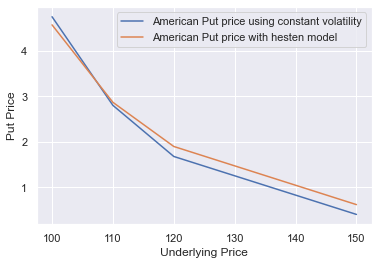

In [15]:
S= [100,110,120, 150]
option_Am = [AMC_S(ss) for ss in S]
option_Am_using_Hesten = [AMC_Hesten_S(ss) for ss in S]
plt.plot(S, option_Am, label='American Put price using constant volatility')
plt.plot(S, option_Am_using_Hesten, label='American Put price with hesten model')
plt.legend()
plt.xlabel('Underlying Price')
plt.ylabel('Put Price')

In [16]:
from ipywidgets import interact
import ipywidgets as widgets
interact(AMC_Hesten_S, S=widgets.FloatSlider(min=50, max=120, step=5))

interactive(children=(FloatSlider(value=50.0, description='S', max=120.0, min=50.0, step=5.0), Output()), _dom…

<function __main__.AMC_Hesten_S(S)>